>
> # Shared rides with pricing

 ### Changes to:
 * shared.py
 * new function `pool_price.py` (with a debugging logs to see what is happening)
 * used inside `decisions.py\f_match
 * traveller.py (different routine - slightly)
 
 ### Usman choice logic to be applied inside `pool_price.py` 
 (now it is random choice)
 
 ### Tested for Delft, 10 paxes in 10 minutes is enough to debug
 > This notebook was fully working and not thoroughly tested


In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

prepare

In [2]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging

In [3]:
import pandas as pd

In [4]:
import ExMAS

In [5]:
params = get_config('../../data/config/delft.json')  # load configuration

In [7]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 10 # reuqests (and passengers)
params.nV = 10 # vehicles

In [117]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True

params.shareability.comm_rate = 0.2

In [118]:
inData = load_G(inData, params)  # load network graph 

In [119]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

In [120]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

18-01-23 13:23:32-INFO-Initializing pairwise trip shareability between 20 and 20 trips.
18-01-23 13:23:32-INFO-creating combinations
18-01-23 13:23:32-INFO-380	 nR*(nR-1)
18-01-23 13:23:33-INFO-Reduction of feasible pairs by 97.63%
18-01-23 13:23:33-INFO-Degree 2 	Completed
18-01-23 13:23:33-INFO-trips to extend at degree 2 : 30
18-01-23 13:23:33-INFO-At degree 2 feasible extensions found out of 5 searched
18-01-23 13:23:33-INFO-Degree 3 	Completed
18-01-23 13:23:33-INFO-trips to extend at degree 3 : 5
18-01-23 13:23:33-INFO-At degree 3 feasible extensions found out of 0 searched
18-01-23 13:23:33-INFO-Degree 4 	Completed
18-01-23 13:23:33-INFO-Max degree reached 4
18-01-23 13:23:33-INFO-Trips still possible to extend at degree 4 : 0


In [121]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

18-01-23 13:23:33-INFO-Matching 20 trips to 55 rides in order to min u_pax
18-01-23 13:23:33-INFO-Problem solution: Optimal. 
Total costs for single trips:             96 
reduced by matching to:                   87


In [122]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],6.590500,356,1,[6.5905000000000005],"[0, 356]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1566353742, 5356459943]","[None, 0, 0]",node time req_id od 0 ...,356,3.56,5.340,1.068,4.272
1,[1],2.842500,153,1,[2.8425],"[4, 153]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 612595747, 44832713]","[None, 1, 1]",node time req_id od 0 N...,153,1.53,2.295,0.459,1.836
2,[2],3.473000,187,1,[3.473],"[21, 187]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44871342, 44845674]","[None, 2, 2]",node time req_id od 0 NaN...,187,1.87,2.805,0.561,2.244
3,[3],2.785500,150,1,[2.7855],"[45, 150]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44843110, 1435362354]","[None, 3, 3]",node time req_id od 0 ...,150,1.50,2.250,0.450,1.800
4,[4],4.239500,229,1,[4.2395000000000005],"[85, 229]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44849730, 2162658839]","[None, 4, 4]",node time req_id od 0 ...,229,2.29,3.435,0.687,2.748
5,[5],2.502000,135,1,[2.5020000000000002],"[125, 135]",[5],[5],1,5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1,"[None, 3995048391, 5591082257]","[None, 5, 5]",node time req_id od 0 ...,135,1.35,2.025,0.405,1.620
6,[6],2.526500,136,1,[2.5265],"[131, 136]",[6],[6],1,6,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,"[None, 3773543334, 44790947]","[None, 6, 6]",node time req_id od 0 ...,136,1.36,2.040,0.408,1.632
7,[7],9.872500,533,1,[9.872499999999999],"[137, 533]",[7],[7],1,7,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0,"[None, 44723195, 298509326]","[None, 7, 7]",node time req_id od 0 N...,533,5.33,7.995,1.599,6.396
8,[8],5.903000,319,1,[5.9030000000000005],"[154, 319]",[8],[8],1,8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,"[None, 44720254, 44790565]","[None, 8, 8]",node time req_id od 0 NaN...,319,3.19,4.785,0.957,3.828
9,[9],3.071000,166,1,[3.071],"[154, 166]",[9],[9],1,9,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44871342, 44852049]","[None, 9, 9]",node time req_id od 0 NaN...,166,1.66,2.490,0.498,1.992


In [123]:
inData.sblts.rides.keys()

Index(['indexes', 'u_pax', 'u_veh', 'kind', 'u_paxes', 'times', 'indexes_orig',
       'indexes_dest', 'degree', 'index', 'PassHourTrav_ns', 'row', 'selected',
       'nodes', 'req_id', 'sim_schedule', 'ttrav', 'dist', 'fare',
       'commission', 'driver_revenue'],
      dtype='object')

simulate

In [124]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

18-01-23 13:23:38-INFO-Matching 20 trips to 55 rides in order to min u_pax
18-01-23 13:23:38-INFO-Problem solution: Optimal. 
Total costs for single trips:             96 
reduced by matching to:                   87
18-01-23 13:23:39-WARNING-Setting up 0.1h simulation at 2023-01-18 13:20:37 for 20 vehicles and 20 passengers in Delft, Netherlands
18-01-23 13:23:39-CRITICAL-this is request 0 with [0, 38, 39] available rides.
18-01-23 13:23:39-CRITICAL-ride 0 available [1]
18-01-23 13:23:39-CRITICAL-ride 38 available [1, 0]
18-01-23 13:23:39-CRITICAL-ride 39 available [1, 0]
18-01-23 13:23:39-CRITICAL-this is reuqest 0 with [0, 38, 39] still available rides.
18-01-23 13:23:39-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 39 of degree 2, with travellers [0, 17].
18-01-23 13:23:39-CRITICAL-this is request 1 with [1, 28, 29] available rides.
18-01-23 13:23:39-CRITICAL-ride 1 available [1]
18-01-23 13:23:39-CRITICAL-ride 28 available [1, 0]
18-01-23 13:23:39-CRITICAL-ride 29 a

In [61]:
pd.DataFrame(sim.vehs[3].myrides)

,veh,pos,t,event,paxes
0,3,3.201817e+09,0.0,STARTS_DAY,[]
1,3,3.201817e+09,0.0,OPENS_APP,[]
2,3,3.201817e+09,21.0,RECEIVES_REQUEST,[]
3,3,3.201817e+09,34.0,ACCEPTS_REQUEST,[]
4,3,3.201817e+09,54.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,3,3.201817e+09,56.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,3,3.377088e+09,364.0,ARRIVES_AT_PICKUP,[]
7,3,3.377088e+09,364.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,3,3.377088e+09,394.0,DEPARTS_FROM_PICKUP,[1]
9,3,4.483188e+07,443.0,ARRIVES_AT_PICKUP,[1]


In [22]:
sim.inData.requests.position

pax
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: position, dtype: int64

In [23]:
df = sim.runs[0].rides
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,4.481126e+07,0.0,STARTS_DAY,[]
1,1,4.481126e+07,0.0,OPENS_APP,[]
2,1,4.481126e+07,0.0,RECEIVES_REQUEST,[]
3,1,4.481126e+07,15.0,ACCEPTS_REQUEST,[]
4,1,4.481126e+07,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,4.481126e+07,351.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,1,2.341955e+09,438.0,ARRIVES_AT_PICKUP,[]
7,1,2.341955e+09,438.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,1,2.341955e+09,468.0,DEPARTS_FROM_PICKUP,[0]
9,1,1.436427e+09,707.0,ARRIVES_AT_PICKUP,[0]


In [24]:
trips = sim.runs[0].trips
trips[trips.pax==8]

,pax,pos,t,event,veh_id
0,8,2106976157,0,STARTS_DAY,NaN
1,8,2106976157,206,RECEIVES_OFFER,NaN
2,8,2106976157,221,ACCEPTS_OFFER,NaN
3,8,2106976157,312,REQUESTS_RIDE,3.0
4,8,2106976157,312,RECEIVES_OFFER,3.0
5,8,2106976157,347,ARRIVES_AT_PICKUP,3.0
6,8,2106976157,559,MEETS_DRIVER_AT_PICKUP,3.0
7,8,2106976157,589,DEPARTS_FROM_PICKUP,3.0
8,8,44840841,1002,ARRIVES_AT_DROPOFF,3.0
9,8,44840841,1012,SETS_OFF_FOR_DEST,NaN


In [25]:
trips[trips.pax==0]

,pax,pos,t,event,veh_id
0,0,2341955079,0,STARTS_DAY,NaN
1,0,2341955079,0,REQUESTS_RIDE,NaN
2,0,2341955079,0,RECEIVES_OFFER,NaN
3,0,2341955079,15,ACCEPTS_OFFER,NaN
4,0,2341955079,35,ARRIVES_AT_PICKUP,1.0
5,0,2341955079,316,RECEIVES_OFFER,1.0
6,0,2341955079,438,MEETS_DRIVER_AT_PICKUP,1.0
7,0,2341955079,468,DEPARTS_FROM_PICKUP,1.0
8,0,265090298,855,ARRIVES_AT_DROPOFF,1.0
9,0,265090298,865,SETS_OFF_FOR_DEST,NaN


In [26]:
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,4.481126e+07,0.0,STARTS_DAY,[]
1,1,4.481126e+07,0.0,OPENS_APP,[]
2,1,4.481126e+07,0.0,RECEIVES_REQUEST,[]
3,1,4.481126e+07,15.0,ACCEPTS_REQUEST,[]
4,1,4.481126e+07,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,4.481126e+07,351.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,1,2.341955e+09,438.0,ARRIVES_AT_PICKUP,[]
7,1,2.341955e+09,438.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,1,2.341955e+09,468.0,DEPARTS_FROM_PICKUP,[0]
9,1,1.436427e+09,707.0,ARRIVES_AT_PICKUP,[0]


<AxesSubplot:>

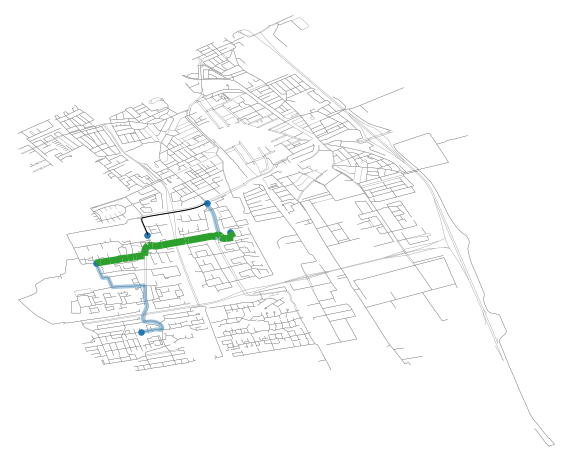

In [27]:
for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==2], lw = 1)

-----